In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import statsmodels.api as sm
from IPython.display import Image



In [ ]:
import os
import pandas as pd

# Define the folder paths
half_hourly_folder = 'Input/hhblock_dataset/hhblock_dataset/'
daily_dataset_folder = 'Input/daily_dataset/daily_dataset/'
new_half_hourly_folder = 'new_half_hourly'  # New folder to save merged files

# Create the new folder if it doesn't exist
if not os.path.exists(new_half_hourly_folder):
    os.makedirs(new_half_hourly_folder)

# Function to process and merge data for one file
def process_and_merge(file_name, block_value=None):
    # Load half-hourly and daily data
    half_hourly_data = pd.read_csv(os.path.join(half_hourly_folder, file_name))
    daily_data = pd.read_csv(os.path.join(daily_dataset_folder, file_name))

    # Convert 'day' column to datetime objects
    half_hourly_data['day'] = pd.to_datetime(half_hourly_data['day']).dt.date
    daily_data['day'] = pd.to_datetime(daily_data['day']).dt.date

    # Merge the dataframes based on 'LCLid' and 'day'
    merged_data = pd.merge(half_hourly_data, daily_data, on=['LCLid', 'day'], how='left')

    # Reorder columns and fill missing energy-related columns with zeros
    energy_cols = ['energy_median', 'energy_mean', 'energy_max', 'energy_count', 'energy_std', 'energy_sum', 'energy_min']
    merged_data[energy_cols] = merged_data[energy_cols].fillna(0)

    # If block_value is provided, add a 'block' column with the specified value
    if block_value:
        merged_data['block'] = block_value

    # Save the merged data to the 'new_half_hourly' folder
    output_file_name = os.path.join(new_half_hourly_folder, 'merged_' + file_name)
    merged_data.to_csv(output_file_name, index=False)

# Process all files in the 'half_hourly' folder
for file_name in os.listdir(half_hourly_folder):
    # Extract the block value from the filename (e.g., block_2.csv)
    block_value = file_name.split('_')[1].split('.')[0] if 'block_' in file_name else None

    process_and_merge(file_name, block_value)


In [ ]:
import pandas as pd

# Read the 'information_households.csv' file
information_file = 'Input/informations_households.csv'
information_data = pd.read_csv(information_file)
new_half_hourly_folder = 'new_half_hourly'  # New folder to save merged files

# Iterate through each unique 'file' value in the 'information_households.csv' file
for block_file in information_data['file'].unique():
    # Filter rows based on the 'file' value
    block_data = information_data[information_data['file'] == block_file]

    # Read the corresponding 'merged_block_X.csv' file from the "new_half_hourly" folder
    merged_block_file = f'merged_{block_file}.csv'
    merged_block_data = pd.read_csv(os.path.join(new_half_hourly_folder, merged_block_file))

    # Merge the data based on the 'LCLid'
    merged_data = pd.merge(merged_block_data, block_data[['LCLid', 'stdorToU', 'Acorn', 'Acorn_grouped']],
                           on='LCLid', how='left')

    # Fill missing values in the 'merged_block_X.csv' file with values from 'information_households.csv'
    for column in ['stdorToU', 'Acorn', 'Acorn_grouped']:
        if f'{column}_x' in merged_data.columns and f'{column}_y' in merged_data.columns:
            merged_data[column] = merged_data[f'{column}_x'].combine_first(merged_data[f'{column}_y'])
        elif f'{column}_x' in merged_data.columns:
            merged_data[column] = merged_data[f'{column}_x']
        elif f'{column}_y' in merged_data.columns:
            merged_data[column] = merged_data[f'{column}_y']

    # Drop the intermediate columns, if they exist
    columns_to_drop = [f'{column}_x' for column in ['stdorToU', 'Acorn', 'Acorn_grouped']] + \
                      [f'{column}_y' for column in ['stdorToU', 'Acorn', 'Acorn_grouped']]
    merged_data = merged_data.drop(columns=columns_to_drop, errors='ignore')

    # Save the updated 'merged_block_X.csv' file in the "new_half_hourly" folder
    merged_data.to_csv(os.path.join(new_half_hourly_folder, merged_block_file), index=False)

In [ ]:
import pandas as pd

# Load your DataFrame from the 'weather_daily.csv' file
weather_data = pd.read_csv('Input/weather_daily_darksky.csv')

# Convert the 'time' column to datetime
weather_data['time'] = pd.to_datetime(weather_data['time'])

# Extract the date in the format 'yyyy-mm-dd' and assign it to the 'day' column
weather_data['day'] = weather_data['time'].dt.strftime('%Y-%m-%d')

# Reorder the columns with 'day' as the first column
weather_data = weather_data[['day'] + [col for col in weather_data.columns if col != 'day']]

# Save the updated DataFrame back to a CSV file
weather_data.to_csv('weather_daily_with_day.csv', index=False)


In [ ]:
import os
import pandas as pd

# Define the folder paths
new_half_hourly_folder = 'new_half_hourly'  # Folder with 'new_half_hourly' files
output_folder = 'new_half_hourly_with_day'  # Folder to save merged files

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Load the weather data
weather_data = pd.read_csv('weather_daily_with_day.csv')

# List the files in the 'new_half_hourly' folder
files = os.listdir(new_half_hourly_folder)

# Iterate through each file in the 'new_half_hourly' folder
for file in files:
    if file.endswith('.csv'):
        # Read the 'new_half_hourly' file
        half_hourly_data = pd.read_csv(os.path.join(new_half_hourly_folder, file))

        # Merge the data based on the 'day' column
        merged_data = pd.merge(half_hourly_data, weather_data, on='day', how='left')

        # Save the updated 'new_half_hourly' file to the output folder
        output_file = os.path.join(output_folder, file)
        merged_data.to_csv(output_file, index=False)


In [ ]:
import os
import pandas as pd

# Source directory with CSV files
source_dir = "new_half_hourly_with_day"

# Destination directory for preprocessed CSV files
dest_dir = "preprocessing"

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Iterate through files in the source directory
for filename in os.listdir(source_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(source_dir, filename)
        dest_file_path = os.path.join(dest_dir, filename)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Select the columns you need
        selected_columns = ['LCLid', 'day'] + [f'hh_{i}' for i in range(48)]
        df = df[selected_columns]

        # Save the preprocessed data to the destination directory
        df.to_csv(dest_file_path, index=False)


In [ ]:
import pandas as pd
import os

# Create a folder to store individual LCLid files
output_folder = "LCLid_files"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# List all files in the "preprocessing" folder
preprocessing_folder = "preprocessing"
all_files = os.listdir(preprocessing_folder)



# Define a function to convert "hh" format to time intervals
def convert_hh_format(hh):
    hours, minutes = divmod(int(hh.split("_")[1]) * 30, 60)
    return f"{hours:02}:{minutes:02}:00"

# Process each file
for file in all_files:
    if file.endswith(".csv"):
        # Read the file into a DataFrame
        df = pd.read_csv(os.path.join(preprocessing_folder, file))
        
        # Group the data by LCLid
        grouped = df.groupby("LCLid")
        
        # Process each unique LCLid
        for name, group_data in grouped:
            # Extract relevant columns
            date_col = group_data[["day"]]
            consumption_col = group_data.iloc[:, 2:50]
            
            # Create a DataFrame with the desired format
            date_time_consumption = pd.concat([date_col, consumption_col], axis=1)
            
            # Reshape the DataFrame to long format
            date_time_consumption = date_time_consumption.melt(id_vars=["day"], var_name="time", value_name="consumption")
            
            # Convert "time" column to time intervals
            date_time_consumption["time"] = date_time_consumption["time"].apply(convert_hh_format)
            
            # Create a "datetime" column by combining "day" and "time"
            date_time_consumption["datetime"] = pd.to_datetime(date_time_consumption["day"] + " " + date_time_consumption["time"])
            
            # Sort by datetime
            date_time_consumption = date_time_consumption.sort_values(by="datetime")
            
            # Select only the "datetime" and "consumption" columns
            date_time_consumption = date_time_consumption[["datetime", "consumption"]]
            
            # Save the DataFrame as a CSV file named by LCLid
            output_file = os.path.join(output_folder, name + ".csv")
            
            # Check if the file already exists
            if os.path.exists(output_file):
                # Append to the existing file
                date_time_consumption.to_csv(output_file, index=False, mode='a', header=False)
            else:
                # Create a new file if it doesn't exist
                date_time_consumption.to_csv(output_file, index=False)


In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Read the original weather data file
original_weather_data = pd.read_csv("Input/weather_hourly_darksky.csv")

# Select only the "temperature" and "time" fields
weather_data = original_weather_data[["time", "temperature"]]

# Convert the "time" field to datetime
weather_data['time'] = pd.to_datetime(weather_data['time'])

# Sort the DataFrame by time in ascending order
weather_data = weather_data.sort_values(by='time')

# Create a new DataFrame for half-hourly data
half_hourly_weather_data = pd.DataFrame()

# Initialize a variable to count the records processed
records_processed = 0

# Initialize index
index = 0

# Iterate through the sorted weather data
while index < len(weather_data):
    row = weather_data.iloc[index]
    half_hourly_weather_data = pd.concat([half_hourly_weather_data, pd.DataFrame([row])])

    next_time = row['time'] + timedelta(minutes=30)
    if index < len(weather_data) - 1 and next_time < weather_data.iloc[index + 1]['time']:
        interpolated_row = row.copy()
        interpolated_row['time'] = next_time
        half_hourly_weather_data = pd.concat([half_hourly_weather_data, pd.DataFrame([interpolated_row])])
        records_processed += 1
        print(f"Records Processed: {records_processed} / Total Records: {len(weather_data)}")
    index += 1

# Sort the DataFrame by time
half_hourly_weather_data = half_hourly_weather_data.sort_values(by='time')

# Forward-fill temperature values for missing half-hourly records
half_hourly_weather_data['temperature'].fillna(method='ffill', inplace=True)

# Save the half-hourly weather data to a new CSV file
half_hourly_weather_data.to_csv("half_hourly_weather.csv", index=False)


In [ ]:
import os
import pandas as pd

# Create a folder to store the output files
if not os.path.exists("LCLid_files_with_temp"):
    os.makedirs("LCLid_files_with_temp")

# Load the half-hourly weather data
weather_data = pd.read_csv("half_hourly_weather.csv")

# Get the list of files in the LCLid_files folder
input_folder = "LCLid_files"
all_files = os.listdir(input_folder)

# Iterate through each file
for file in all_files:
    if file.endswith(".csv"):
        # Read the LCLid file
        df = pd.read_csv(os.path.join(input_folder, file))
        
        # Merge the LCLid data with the weather data based on both 'datetime' and 'time' columns
        merged_df = pd.merge(df, weather_data, left_on="datetime", right_on="time", how="left")
        
        # Create a new folder for output files if it doesn't exist
        output_folder = "LCLid_files_with_temp"
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        # Save the merged data to a new CSV file
        output_file = os.path.join(output_folder, file)
        merged_df.to_csv(output_file, index=False)


In [ ]:
import os
import pandas as pd

# Define the directory containing the CSV files
data_dir = "LcLid_files_with_temp"

# Initialize an empty list to store DataFrames
dataframes = []

# Iterate through the files in the directory
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        # Extract the household ID from the filename
        household = filename.split(".")[0]

        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(data_dir, filename), usecols=["datetime", "consumption", "temperature"])

        # Add the "household" column with the corresponding household ID
        df["household"] = household

        # Append the DataFrame to the list
        dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_data = pd.concat(dataframes, ignore_index=True)

# Sort the combined DataFrame by "datetime" and "household"
combined_data.sort_values(by=["datetime", "household"], inplace=True)

# Save the combined data to a single CSV file
combined_data.to_csv("combined_data.csv", index=False)

# The combined data is now saved to "combined_data.csv" in the current working directory.


The following is the process for training a Simple RNN 

/var/folders/1t/lfw759z149sg89rttrgb_rtw0000gn/T/ipykernel_26084/2914229669.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['consumption'].fillna(mean_consumption, inplace=True)
/var/folders/1t/lfw759z149sg89rttrgb_rtw0000gn/T/ipykernel_26084/2914229669.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['consumption'].fillna(mean_consumption, inplace=True)


X_train shape: (80264,)
y_train shape: (80264,)
Finished training
Training time: 42.02 seconds
[0.08873619139194489, 0.08749312162399292, 0.08761018514633179, 0.08739767968654633, 0.08746302872896194, 0.08760229498147964, 0.08765728026628494, 0.08764021098613739, 0.0880056619644165, 0.0877576619386673, 0.08774254471063614, 0.08799394220113754, 0.08792278915643692, 0.08813554793596268, 0.08815638720989227, 0.08809392899274826, 0.08790340274572372, 0.08786364644765854, 0.0879894495010376, 0.08825481683015823, 0.08825709670782089, 0.08858440816402435, 0.08853664994239807, 0.08834211528301239, 0.08849936723709106, 0.08842938393354416, 0.08856739848852158, 0.08871012181043625, 0.08899573236703873, 0.0888155996799469, 0.08858127892017365, 0.08869476616382599, 0.08907797932624817, 0.08917692303657532, 0.08900631964206696, 0.0889698714017868, 0.08935420215129852, 0.08903685212135315, 0.08897816389799118, 0.08878426253795624, 0.08929581940174103, 0.0892782062292099, 0.08906827867031097, 0.08866

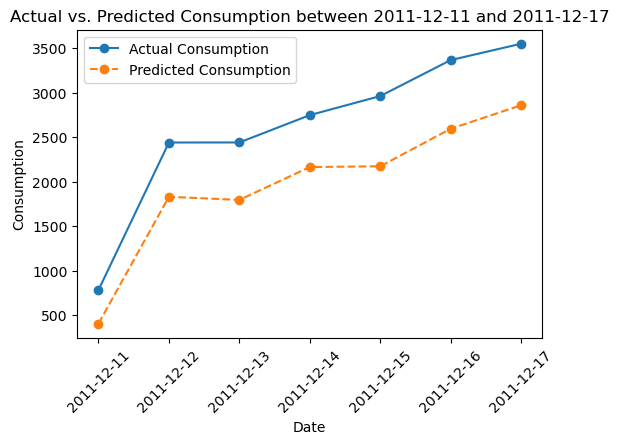

In [6]:
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tabulate import tabulate
import time
import tensorflow as tf


epoch = 50
# Function to create and train a S
# imple RNN model
def train_rnn_model(X_train, y_train):
    model = Sequential()
    model.add(SimpleRNN(32, activation='relu', input_shape=(None, 1)))
    model.add(Dense(1))
    optimizer = Adam(clipvalue=0.5)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=32, verbose=0)
    return model

# Function to predict and return results
def predict(model, X_test):
    predicted_values = model.predict(X_test)
    return predicted_values

# Load data from combined_data.csv
percentage_to_load = 100
data = pd.read_csv("combined_data.csv", usecols=['datetime', 'consumption', 'temperature', 'household'], nrows=int(percentage_to_load / 100 * len(pd.read_csv("combined_data.csv"))))

# Sort the data by datetime
data['datetime'] = pd.to_datetime(data['datetime'])
data.sort_values(by='datetime', inplace=True)

# Split the data into training (70%) and testing (30%)
unique_datetimes = data['datetime'].unique()
train_size = int(0.7 * len(unique_datetimes))
train_datetimes = unique_datetimes[:train_size]
test_datetimes = unique_datetimes[train_size:]
train_data = data[data['datetime'].isin(train_datetimes)]
test_data = data[data['datetime'].isin(test_datetimes)]

# Calculate the mean of the 'consumption' column
mean_consumption = train_data['consumption'].mean()
train_data['consumption'].fillna(mean_consumption, inplace=True)
test_data['consumption'].fillna(mean_consumption, inplace=True)

# Prepare the training data
X_train = train_data['temperature'].values
y_train = train_data['consumption'].values
# Check the dimensions of X_train and y_train
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train = X_train.reshape(-1, 1, 1)



# Create and train a Simple RNN model

start_time = time.time()
# Perform model training here
model = train_rnn_model(X_train, y_train)
print("Finished training")
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

history = model.history.history

# Now you can use or save the training history as needed
training_loss = history['loss']
validation_loss = history.get('val_loss', None)

print(training_loss)
print(validation_loss)
# Prepare the testing data
X_test = test_data['temperature'].values
y_test = test_data['consumption'].values
# Check the dimensions of X_train and y_train
print(f"X_train shape: {X_test.shape}")
print(f"y_train shape: {y_test.shape}")

X_test = X_test.reshape(-1, 1, 1)


start_time = time.time()
# Perform model testing here
# Make predictions using the model
predicted_values = predict(model, X_test)
end_time = time.time()
testing_time = end_time - start_time
print(f"Testing time: {testing_time:.2f} seconds")


# Check for NaN values in the NumPy array
nan_indices = np.isnan(predicted_values)
mean_value = np.nanmean(predicted_values)
predicted_values[nan_indices] = mean_value
print("Finished testing")

print('Calculate metrics for the testing data') 
mse = mean_squared_error(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
r2 = r2_score(y_test, predicted_values)

# Calculate MAPE
mape = 100 * (mae / np.mean(y_test))

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R-squared (R2): {r2:.2f}')
print('Mean Absolute Percentage Error (MAPE): {:.2f}%'.format(mape))
print("this is individual")

# Create a list of metrics and their values
metrics_data = [
    ['MSE', mse],
    ['MAE', mae],
    ['R2', r2],
    ['MAPE', mape],
    ['Training Time', training_time],
    ['Testing Time', testing_time],
    ['Epochs', epoch]
]

# Create the "metrics" folder if it doesn't exist
metrics_folder = 'metrics'
if not os.path.exists(metrics_folder):
    os.makedirs(metrics_folder)

# Set the path to save the table file
table_file_path = os.path.join(metrics_folder, 'RNN_daily_individual_metrics.txt')

# Print metrics in a table
table = tabulate(metrics_data, headers=['Metric', 'Value'], tablefmt='grid')


# Save the table to the specified file path
with open(table_file_path, "w") as file:
    file.write(table)
# Calculate the number of days for the test data
num_days = len(test_data['datetime'].dt.date.unique())

# Create a DataFrame for predicted data with the same datetime values
predicted_data = pd.DataFrame({'datetime': test_data['datetime'], 'consumption': predicted_values[:, 0]})

# Create a DataFrame for test data
test_data_df = pd.DataFrame({'datetime': test_data['datetime'], 'consumption': test_data['consumption']})

# Aggregate daily test consumption data
daily_test_data = test_data_df.groupby(test_data_df['datetime'].dt.date)['consumption'].sum()

# Aggregate daily predicted consumption data
daily_predicted_data = predicted_data.groupby(predicted_data['datetime'].dt.date)['consumption'].sum()


only_daily_test_data = daily_test_data.values
only_predicted_data = daily_predicted_data.values


print('Calculate metrics for the testing data') 
mse = mean_squared_error(only_daily_test_data, only_predicted_data)
mae = mean_absolute_error(only_daily_test_data, only_predicted_data)
r2 = r2_score(only_daily_test_data, only_predicted_data)

# Calculate MAPE
mape = 100 * (mae / np.mean(only_daily_test_data))

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R-squared (R2): {r2:.2f}')
print('Mean Absolute Percentage Error (MAPE): {:.2f}%'.format(mape))

# Create a list of metrics and their values
aggregate_metrics_data = [
    ['MSE', mse],
    ['MAE', mae],
    ['R2', r2],
    ['MAPE', mape],
    ['Training Time', training_time],
    ['Testing Time', testing_time],
    ['Epochs', epoch]
]

# Create the "metrics" folder if it doesn't exist
metrics_folder = 'metrics'
if not os.path.exists(metrics_folder):
    os.makedirs(metrics_folder)

# Set the path to save the table file
table_file_path = os.path.join(metrics_folder, 'RNN_daily_aggregate_metrics.txt')

# Print metrics in a table
table = tabulate(aggregate_metrics_data, headers=['Metric', 'Value'], tablefmt='grid')

# Print the table to the console
print(table)

# Save the table to the specified file path
with open(table_file_path, "w") as file:
    file.write(table)
# Get the unique dates in the data
#unique_dates = daily_test_data.index

# Create a plot
#plt.figure(figsize=(12, 6))
#plt.plot(unique_dates, daily_test_data.values, marker='o', label='Actual Consumption', linestyle='-')
#plt.plot(unique_dates, daily_predicted_data.values, marker='o', label='Predicted Consumption', linestyle='--')

#plt.xlabel('Date')
#plt.ylabel('Consumption')
#plt.title('Actual vs. Predicted Consumption for Each Day')
#plt.legend()
#plt.show()


# Get the unique dates in the data
unique_dates = daily_test_data.index
value = 7
# Iterate through the unique dates, creating a plot for each pair of dates
for i in range(0, len(unique_dates), value):
    if i + value-1 < len(unique_dates):
        dateArray = []
        for n in range(i,i+value):
            date = unique_dates[n]
            dateArray.append(date)

        date1 = unique_dates[i]
        date2 = unique_dates[i + 1]
        # Get consumption values for the two dates
        consumptionarray = []
        for date in dateArray:
            consumption = daily_test_data.loc[date]
            consumptionarray.append(consumption)

        # Get predicted consumption values for the two dates (adjust the data source accordingly)
        # Get consumption values for the two dates
        pconsumptionarray = []
        for date in dateArray:
            consumption = daily_predicted_data.loc[date]
            pconsumptionarray.append(consumption)

        # Create a plot with actual and predicted consumption
        plt.figure(figsize=(6, 4))
        plt.plot(dateArray, consumptionarray, marker='o', label='Actual Consumption', linestyle='-')
        plt.plot(dateArray, pconsumptionarray, marker='o', label='Predicted Consumption', linestyle='--')

        plt.xlabel('Date')
        plt.ylabel('Consumption')
        plt.title(f'Actual vs. Predicted Consumption between {dateArray[0]} and {dateArray[-1]}')
        plt.legend()
        
        # Set the x-axis ticks and format date labels
        date_ticks = dateArray
        date_labels = [date.strftime('%Y-%m-%d') for date in date_ticks]
        plt.xticks(date_ticks, date_labels, rotation=45)
        
        # Save the plot to a folder named "plots"
        if not os.path.exists("rnn_plots"):
            os.makedirs("rnn_plots")
        plt.savefig(f"plots/RNN_{dateArray[0]}_to_{dateArray[-1]}.png")
        
        plt.show()


    # Clear the current figure
    plt.clf()

    # Close the plot window
    plt.close()









The following is for training an LSTM